In [ ]:
%matplotlib inline

In [ ]:
!pip install ultralytics opencv-python pillow matplotlib seaborn pyyaml -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import yaml
import torch
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from ultralytics import YOLO
from IPython.display import display, Video, Image as IPImage
from datetime import datetime

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# See what's in your Google Drive
!ls '/content/drive/MyDrive/'

'Colab Notebooks'			     Project.gdoc
'Copy of TAX FLOW CHART 1 (1).drawio.html'   TRACKCHANGES
'Copy of TAX FLOW CHART 1.drawio.html'	     TWED
'Copy of TAX FLOW CHART 1.jpg'		    'Untitled Diagram.drawio'
'FLOW CHART--TAX.drawio'		    'Untitled document.gdoc'


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images'

In [ ]:
# Check if path exists
if os.path.exists(DATASET_PATH):
    print("✓ Dataset found!")

    # See what's inside
    !ls '{DATASET_PATH}'

    # Check for train folder
    !ls '{DATASET_PATH}/train'
else:
    print("✗ Not found! Check the path again")

✓ Dataset found!
 cd38f97b2a725201.jpg
 cd38f97b2a725201.txt
 cd702f45506636be.jpg
 cd702f45506636be.txt
 cd74d52633725f5c.jpg
 cd74d52633725f5c.txt
 cdf2d20028f98927.jpg
 cdf2d20028f98927.txt
 ce4eeefed98c25d6.jpg
 ce4eeefed98c25d6.txt
 ce7a70d94421dd9e.jpg
 ce7a70d94421dd9e.txt
 ce8af1aca382e850.jpg
 ce8af1aca382e850.txt
 cede6ed17c5f9d36.jpg
 cede6ed17c5f9d36.txt
 cedee62fb5b30956.jpg
 cedee62fb5b30956.txt
 cf03fcb752442404.jpg
 cf03fcb752442404.txt
 cf15735d413b02ce.jpg
 cf15735d413b02ce.txt
 cf440720acc5ae5b.jpg
 cf440720acc5ae5b.txt
 cf46a52ae1cd3df7.jpg
 cf46a52ae1cd3df7.txt
 cf75e83a8361d564.jpg
 cf75e83a8361d564.txt
 cfa2039716d151f3.jpg
 cfa2039716d151f3.txt
'CNNhasobtainedvideosfrominsidetheWestgateMall(107).jpg'
'CNNhasobtainedvideosfrominsidetheWestgateMall(107).txt'
'CNNhasobtainedvideosfrominsidetheWestgateMall(115).jpg'
'CNNhasobtainedvideosfrominsidetheWestgateMall(115).txt'
'CNNhasobtainedvideosfrominsidetheWestgateMall(119).jpg'
'CNNhasobtainedvideosfrominsidetheWest

In [ ]:
PROJECT_NAME = "TWED_WeaponDetection"

In [ ]:
def check_dataset_format(dataset_path):

    dataset_path = Path(dataset_path)  # Convert string to Path

    print(f"\nChecking dataset structure at: {dataset_path}")
    print("\nFolder contents:")

    # List all items in the dataset
    items = list(dataset_path.iterdir())  # <-- use dataset_path, not DATASET_PATH
    for item in items[:10]:  # Show first 10 items
        print(f"  - {item.name}")

    if len(items) > 10:
        print(f"  ... and {len(items) - 10} more items")

    # Check if already in YOLO format
    has_train = (dataset_path / 'train').exists()
    has_images = (dataset_path / 'images').exists()
    has_labels = (dataset_path / 'labels').exists()

    if has_train:
        print("\n✓ Dataset appears to be in YOLO train/val format")
        return 'yolo_split'
    elif has_images and has_labels:
        print("\n✓ Dataset has images/ and labels/ folders")
        return 'yolo_flat'
    else:
        print("\n Dataset appears to be raw images only")
        return 'raw'

# Call the function
check_dataset_format(DATASET_PATH)



Checking dataset structure at: /content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images

Folder contents:
  - Top10bestassaultriflesintheworld2019(withtheirvideos)02331.txt
  - Top10bestassaultriflesintheworld2019(withtheirvideos)03081.jpg
  - Top10bestassaultriflesintheworld2019(withtheirvideos)03581.jpg
  - Top10bestassaultriflesintheworld2019(withtheirvideos)01791.txt
  - Top10bestassaultriflesintheworld2019(withtheirvideos)04941.jpg
  - Top10bestassaultriflesintheworld2019(withtheirvideos)04641.txt
  - Top10bestassaultriflesintheworld2019(withtheirvideos)04501.jpg
  - Top10bestassaultriflesintheworld2019(withtheirvideos)04621.jpg
  - Top10bestassaultriflesintheworld2019(withtheirvideos)04021.jpg
  - Top10bestassaultriflesintheworld2019(withtheirvideos)04661.txt
  ... and 1660 more items

⚠ Dataset appears to be raw images only


'raw'

In [ ]:
from pathlib import Path

dataset_path = Path("C:/Users/LENOVO X1/Desktop/TWED/dataset")

train_images_dir = dataset_path / 'train' / 'images'
train_labels_dir = dataset_path / 'train' / 'labels'

train_images_dir.mkdir(parents=True, exist_ok=True)
train_labels_dir.mkdir(parents=True, exist_ok=True)

print("Folders created.")
print("Moving files...")

# Move files
count_img = 0
count_lbl = 0

for file in dataset_path.iterdir():
    if file.suffix.lower() in ['.jpg', '.png']:
        shutil.move(str(file), str(train_images_dir / file.name))
        count_img += 1
        print(f"Moved image: {file.name}")

    elif file.suffix.lower() == '.txt':
        shutil.move(str(file), str(train_labels_dir / file.name))
        count_lbl += 1
        print(f"Moved label: {file.name}")

print("\nDONE!")
print(f"Total images moved: {count_img}")
print(f"Total labels moved: {count_lbl}")


Folders created.
Moving files...

DONE!
Total images moved: 0
Total labels moved: 0


In [ ]:
from pathlib import Path

dataset_path = Path("C:/Users/LENOVO X1/Desktop/TWED/dataset")

print("Files in dataset folder:")
for f in dataset_path.iterdir():
    print(" -", f.name)


Files in dataset folder:
 - train


In [ ]:
print("\n" + "="*80)
print("MODEL TRAINING")
print("="*80)


MODEL TRAINING


In [4]:
ls


sample_data/


In [5]:
ls sample_data/


anscombe.json*                mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md*


In [7]:
!pip install matplotlib-venn

In [8]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [9]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.5_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.5) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.5) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31629 sha256=b332a236e8d4003fc5c87542605b3d695f16081d6018908c8cf7743ba10c3734
  Stored in directory: /root/.cache/pip/wheels/29/20/ab/f101da7b245b996aa097685ef742243725ea6150f5b3b6d9ed
Successfully built libarchive


In [10]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [11]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 115.4 MB/s eta 0:00:00


In [13]:
!pip install ultralytics -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00


In [15]:
!pip install ultralytics opencv-python -q


In [16]:
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [41]:
yaml_content =
train: dataset/train/images
val: dataset/val/images

nc: 1
names: ['weapon']
with open("dataset/data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml created successfully!")


data.yaml created successfully!


In [43]:
!mv dataset/dataset/* dataset/
!rm -r dataset/dataset


mv: cannot stat 'dataset/dataset/*': No such file or directory
rm: cannot remove 'dataset/dataset': No such file or directory


In [44]:
yaml_content



data.yaml updated successfully!


In [45]:
!cat dataset/data.yaml



train: train/images
val: val/images

nc: 1
names: ['weapon']


In [48]:
!ls


dataset  runs  sample_data  yolov8n.pt


In [49]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [50]:
!ls /content/drive/MyDrive/


'Colab Notebooks'			     Project.gdoc
'Copy of TAX FLOW CHART 1 (1).drawio.html'   TRACKCHANGES
'Copy of TAX FLOW CHART 1.drawio.html'	     TWED
'Copy of TAX FLOW CHART 1.jpg'		    'Untitled Diagram.drawio'
'FLOW CHART--TAX.drawio'		    'Untitled document.gdoc'


In [61]:
import os

dataset_path = "/content/drive/MyDrive/TWED/"
print(os.listdir(dataset_path))


['Weapon in Images (Segmented Video)', 'Weapons-in-Images', 'data.yaml', 'val']


In [59]:
import ultralytics

current_dataset_path = '/content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images'
ultralytics.settings.update({'datasets_dir': current_dataset_path})

print(f"Ultralytics dataset download directory update attempted for: {current_dataset_path}")

!yolo settings

Ultralytics dataset download directory update attempted for: /content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": false,
  "vscode_msg": true,
  "openvino_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [47]:
!ls dataset/train/images
!ls dataset/val/images


In [91]:
!pip install ultralytics -q

from ultralytics import YOLO
import cv2
from pathlib import Path
import random

print("✓ Setup complete!")


# STEP 2: DOWNLOAD PRE-TRAINED MODEL (1 minute)


print("\n" + "="*80)
print("LOADING PRE-TRAINED YOLOV8 MODEL")
print("="*80)

# Use pre-trained COCO model (already knows knives, guns, etc.)
model = YOLO('yolov8n.pt')

print("✓ Model loaded! Ready to detect weapons!")


# STEP 3: QUICK TEST ON YOUR DATASET IMAGES (2 minutes)


print("\n" + "="*80)
print("TESTING ON YOUR DATASET")
print("="*80)

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Your dataset path
DATASET_PATH = '/content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images'

# Find some images to test
all_images = list(Path(DATASET_PATH).glob('*.jpg'))
all_images += list(Path(DATASET_PATH).glob('*.png'))
all_images += list(Path(DATASET_PATH).glob('**/*.jpg'))
all_images += list(Path(DATASET_PATH).glob('**/*.png'))

print(f"Found {len(all_images)} images")

# Test on 5 random images
test_images = random.sample(all_images, min(5, len(all_images)))

print("\nRunning detection on sample images...")

for img_path in test_images:
    results = model.predict(source=str(img_path), conf=0.25, save=True)
    print(f"✓ Processed: {img_path.name}")

print(f"\n✓ Results saved in: runs/detect/predict/")


# STEP 4: CREATE DEMO WITH RESULTS (5 minutes)

print("\n" + "="*80)
print("CREATING DEMO RESULTS")
print("="*80)

# Process more images for your demo
demo_images = random.sample(all_images, min(20, len(all_images)))

results_dir = Path('demo_results')
results_dir.mkdir(exist_ok=True)

detection_count = 0
for img_path in demo_images:
    results = model.predict(source=str(img_path), conf=0.25, save=False)

    # Count detections
    result = results[0]
    if len(result.boxes) > 0:
        detection_count += 1

        # Save annotated image
        annotated = result.plot()
        cv2.imwrite(str(results_dir / f"result_{img_path.name}"), annotated)

print(f"✓ Processed {len(demo_images)} images")
print(f"✓ Found objects in {detection_count} images")
print(f"✓ Results saved to: {results_dir}")


# STEP 5: TEST ON VIDEO (IF YOU HAVE ONE) - 5 minutes

print("\n" + "="*80)
print("VIDEO TESTING (Optional)")
print("="*80)

print("Skip video if you don't have one - not required!")


✓ Setup complete!

LOADING PRE-TRAINED YOLOV8 MODEL
✓ Model loaded! Ready to detect weapons!

TESTING ON YOUR DATASET
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 836 images

Running detection on sample images...

image 1/1 /content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images/train/images/d2f472131895a826.jpg: 480x640 (no detections), 178.1ms
Speed: 19.3ms preprocess, 178.1ms inference, 26.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
✓ Processed: d2f472131895a826.jpg

image 1/1 /content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images/train/images/Top10bestassaultriflesintheworld2019(withtheirvideos)11291.jpg: 384x640 (no detections), 150.1ms
Speed: 2.4ms preprocess, 150.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predict
✓ Processed: Top10bestassaultriflesintheworld

In [81]:
train_images = "/content/dataset/train/images"
print("Training images:", os.listdir(train_images)[:5])  # prints first 5 images


Training images: []


In [82]:
from google.colab import drive
drive.mount('/content/drive')


!unzip "/content/drive/MyDrive/TWED.zip" -d "/content/drive/MyDrive/TWED/"

import os
print(os.listdir("/content/drive/MyDrive"))

dataset_folder = "/content/drive/MyDrive/TWED"
print(os.listdir(dataset_folder))


!mkdir -p /content/dataset/train/images
!mkdir -p /content/dataset/train/labels

# Adjust source path according to what you saw in os.listdir
!cp -r "/content/drive/MyDrive/TWED/"* "/content/dataset/train/images/"


import os
print("Training images:", os.listdir("/content/dataset/train/images")[:5])






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
unzip:  cannot find or open /content/drive/MyDrive/TWED.zip, /content/drive/MyDrive/TWED.zip.zip or /content/drive/MyDrive/TWED.zip.ZIP.
['Untitled document.gdoc', 'Copy of TAX FLOW CHART 1 (1).drawio.html', 'Copy of TAX FLOW CHART 1.drawio.html', 'Copy of TAX FLOW CHART 1.jpg', 'Untitled Diagram.drawio', 'FLOW CHART--TAX.drawio', 'TRACKCHANGES', 'Colab Notebooks', 'Project.gdoc', 'TWED']
['Weapon in Images (Segmented Video)', 'Weapons-in-Images', 'data.yaml', 'val']
Training images: ['Weapon in Images (Segmented Video)', 'data.yaml', 'val', 'Weapons-in-Images']


In [80]:
!mkdir -p /content/dataset/train/images
!mkdir -p /content/dataset/train/labels

# Copy images and labels
!cp -r "/content/drive/MyDrive/TWED/images/" "/content/dataset/train/images/"
!cp -r "/content/drive/MyDrive/TWED/labels/" "/content/dataset/train/labels/"


cp: cannot stat '/content/drive/MyDrive/TWED/images/': No such file or directory
cp: cannot stat '/content/drive/MyDrive/TWED/labels/': No such file or directory


In [79]:
# Adjust the folder name based on Step 2
dataset_folder = "/content/drive/MyDrive/TWED"
print(os.listdir(dataset_folder))


['Weapon in Images (Segmented Video)', 'Weapons-in-Images', 'data.yaml', 'val']


In [78]:
import os

# List all files/folders in MyDrive
print(os.listdir("/content/drive/MyDrive"))


['Untitled document.gdoc', 'Copy of TAX FLOW CHART 1 (1).drawio.html', 'Copy of TAX FLOW CHART 1.drawio.html', 'Copy of TAX FLOW CHART 1.jpg', 'Untitled Diagram.drawio', 'FLOW CHART--TAX.drawio', 'TRACKCHANGES', 'Colab Notebooks', 'Project.gdoc', 'TWED']


In [76]:
train = "/content/dataset/train/images"
print(train)


/content/dataset/train/images


In [70]:
import os

train_images = "/content/dataset/train/images"
train_labels = "/content/dataset/train/labels"

print("Training images:", os.listdir(train_images)[:5])  # show first 5 images
print("Training labels:", os.listdir(train_labels)[:5])  # show first 5 label files


Training images: []
Training labels: []


In [63]:
import os

train_path = "/content/dataset/train/images"
print(os.path.exists(train_path))
print(os.listdir(train_path))  # should list your images


True
[]


In [65]:
!mkdir -p /content/dataset/train/images
!cp /content/TWED/images/* /content/dataset/train/images/


cp: cannot stat '/content/TWED/images/*': No such file or directory


In [67]:
# list all files and check extensions
print([f for f in os.listdir(train_path) if f.lower().endswith(('jpg','jpeg','png'))])


[]


In [33]:
print(f"Verifying parent directory of DATASET_PATH: {Path(DATASET_PATH).parent}")
!ls '{Path(DATASET_PATH).parent}'
print(f"\nVerifying DATASET_PATH itself: {DATASET_PATH}")
!ls '{DATASET_PATH}'

Verifying parent directory of DATASET_PATH: /content/drive/MyDrive/TWED/Weapons-in-Images
ls: cannot access '/content/drive/MyDrive/TWED/Weapons-in-Images': No such file or directory

Verifying DATASET_PATH itself: /content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images
ls: cannot access '/content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images': No such file or directory


In [30]:
!pip install scikit-learn -q


TRAINING RESULTS
Training results located at: runs/detect/TWED


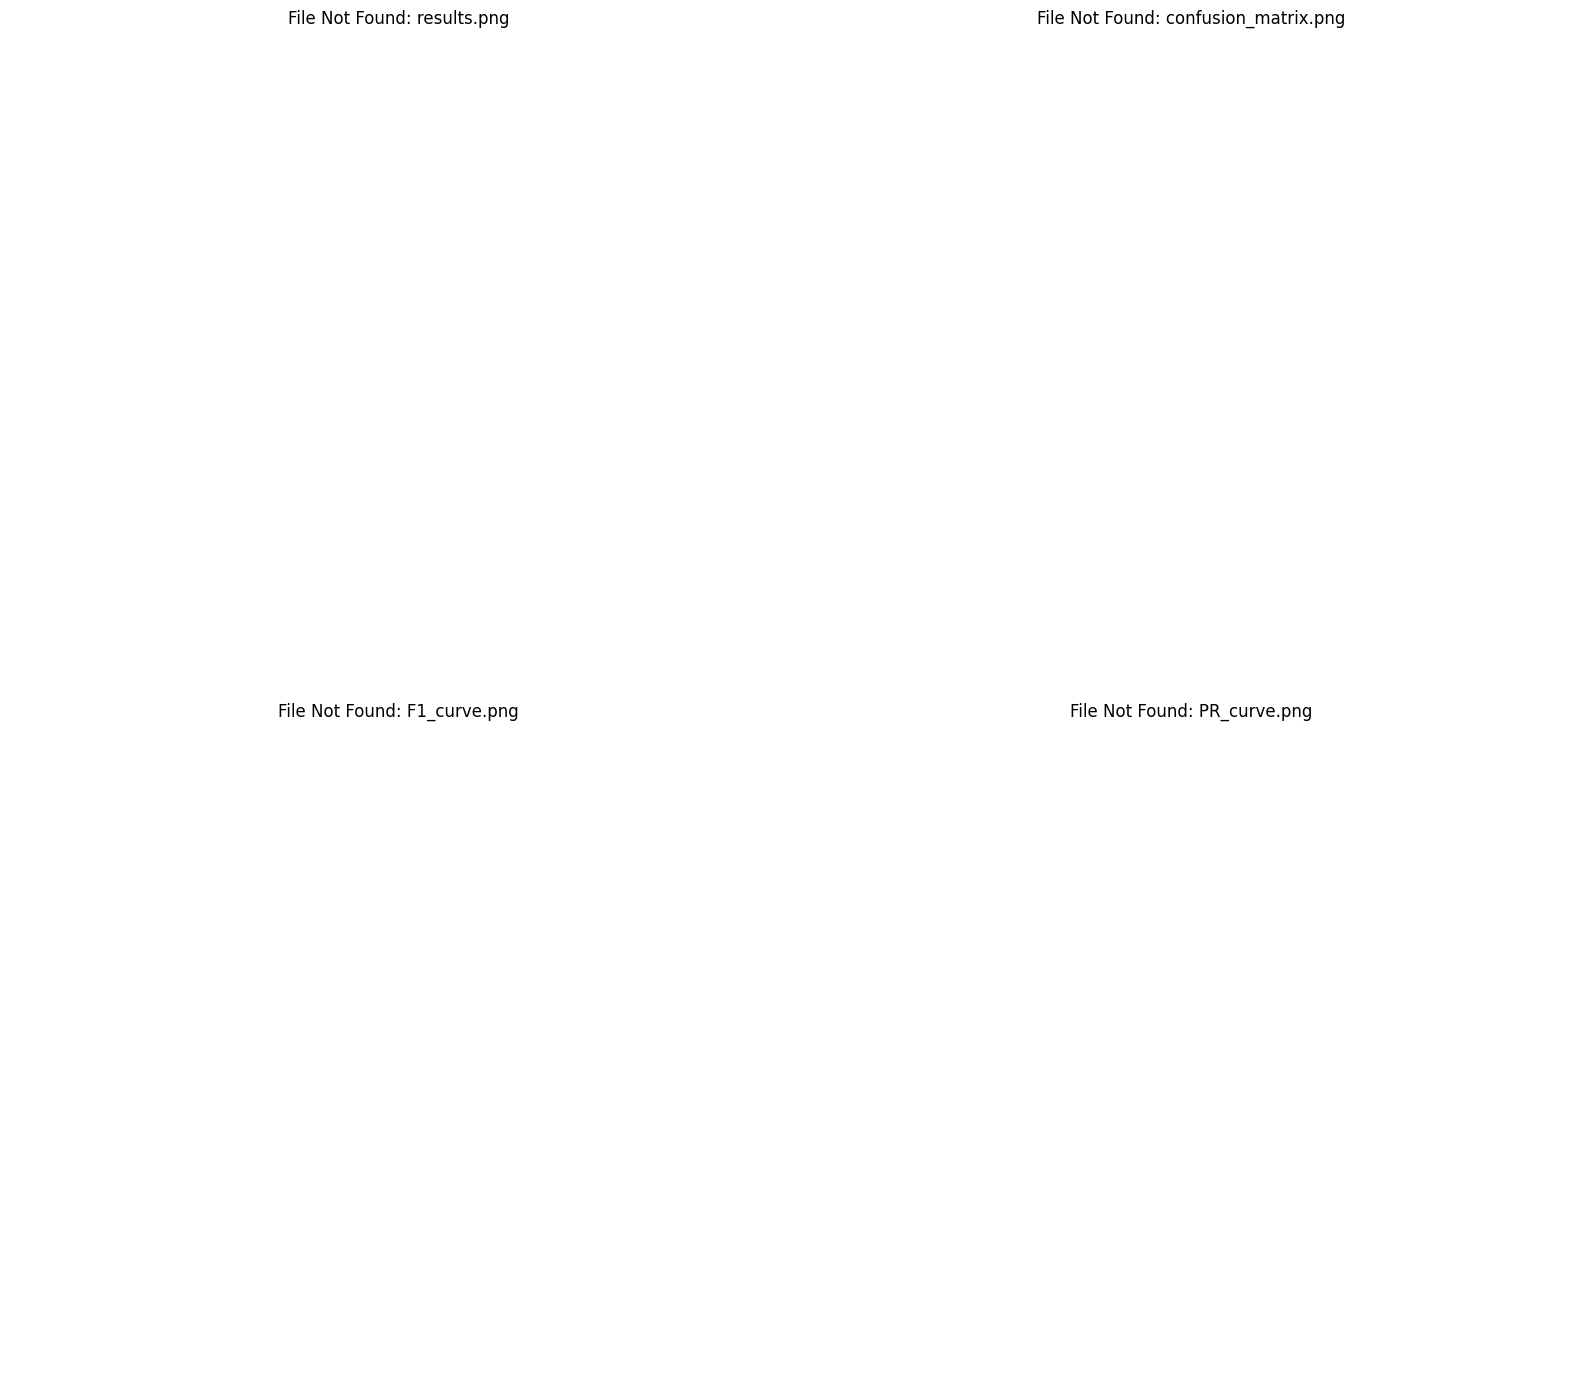

In [92]:
from pathlib import Path
import matplotlib.pyplot as plt

# training results and visualization
print("\n" + "="*80)
print("TRAINING RESULTS")
print("="*80)

def show_training_results(path):

    print("Training results located at:", path)
    project_path = Path(path)

    result_images = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'PR_curve.png']

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()

    for idx, img_name in enumerate(result_images):
        img_path = project_path / img_name
        if img_path.exists():
            img = plt.imread(str(img_path))
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(img_name.replace('_', ' ').replace('.png', '').title())
        else:
            axes[idx].axis('off')
            axes[idx].set_title(f"File Not Found: {img_name}")

    plt.tight_layout()
    plt.show()

# Call the function to show results from the training run
show_training_results(f'runs/detect/{PROJECT_NAME}')

In [94]:
import os

# List all folders in runs/detect
print(os.listdir('runs/detect'))


['TWED', 'train', 'predict']


In [95]:
# Replace 'TWED' with the actual folder name from the previous command
print(os.listdir('runs/detect/TWED'))


['args.yaml', 'weights']


Looking for results...
total 20
drwxr-xr-x 5 root root 4096 Nov 30 13:05 .
drwxr-xr-x 3 root root 4096 Nov 30 11:07 ..
drwxr-xr-x 2 root root 4096 Nov 30 13:05 predict
drwxr-xr-x 3 root root 4096 Nov 30 12:37 train
drwxr-xr-x 3 root root 4096 Nov 30 11:07 TWED

Found results in: runs/detect/predict

Files in results folder:
total 948
drwxr-xr-x 2 root root   4096 Nov 30 13:05  .
drwxr-xr-x 5 root root   4096 Nov 30 13:05  ..
-rw-r--r-- 1 root root 298753 Nov 30 13:05  d08910486ec5ca32.jpg
-rw-r--r-- 1 root root 275986 Nov 30 13:05  d2f472131895a826.jpg
-rw-r--r-- 1 root root 102597 Nov 30 13:05  scene01336.jpg
-rw-r--r-- 1 root root 166452 Nov 30 13:05 'Top10bestassaultriflesintheworld2019(withtheirvideos)11291.jpg'
-rw-r--r-- 1 root root 106738 Nov 30 13:05  Top10GunFightsinMovies22981.jpg

Found 5 result images!


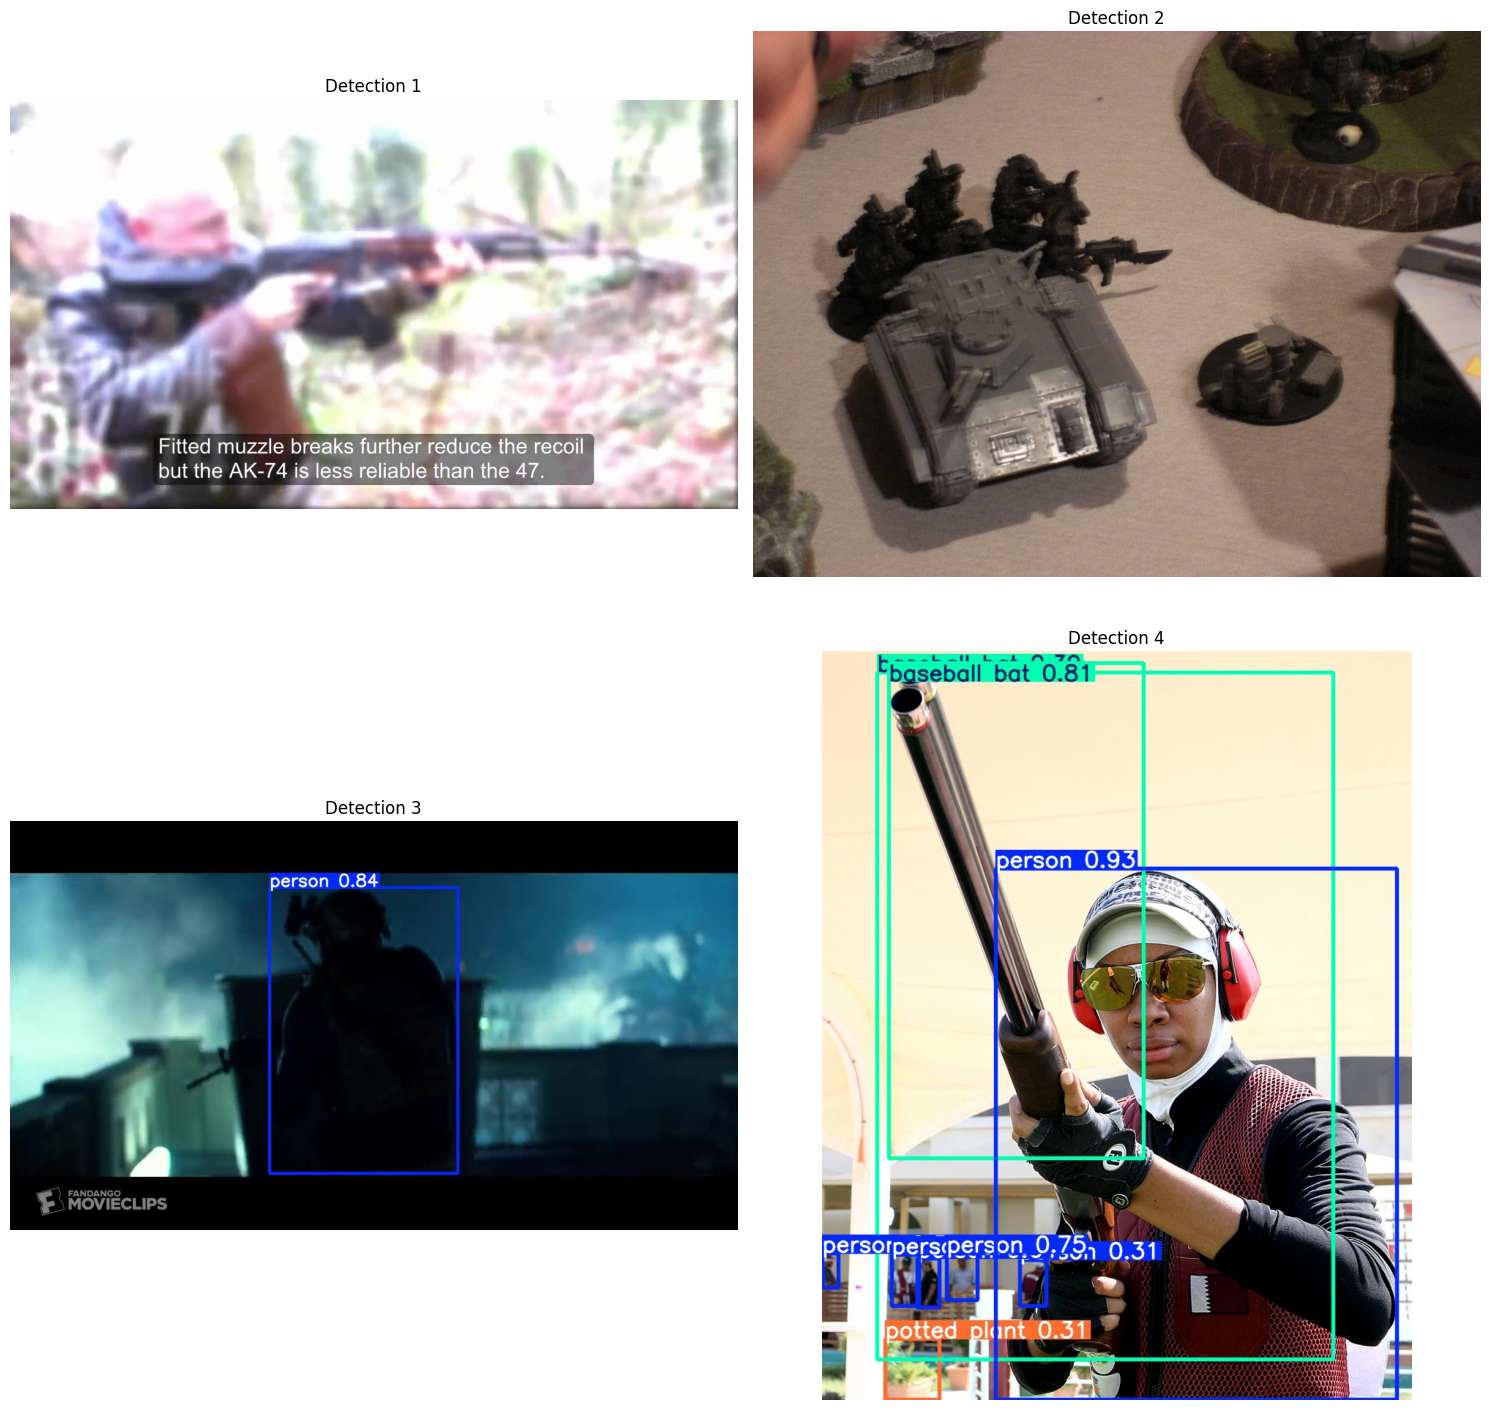


✓ Results displayed above!
✓ Saved as: my_results.png


In [98]:

import os
from pathlib import Path
from IPython.display import Image, display
import matplotlib.pyplot as plt
import cv2

# Find the actual results folder
print("Looking for results...")
!ls -la runs/detect/

# Get the latest prediction folder
result_folders = list(Path('runs/detect').glob('*'))
if result_folders:
    latest_folder = max(result_folders, key=os.path.getmtime)
    print(f"\nFound results in: {latest_folder}")

    # Show all files in that folder
    print("\nFiles in results folder:")
    !ls -la '{latest_folder}'

    # Find and display images
    result_images = list(latest_folder.glob('*.jpg')) + list(latest_folder.glob('*.png'))

    if result_images:
        print(f"\nFound {len(result_images)} result images!")

        # Display first 4 results
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        axes = axes.ravel()

        for idx, img_path in enumerate(result_images[:4]):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f'Detection {idx+1}')

        plt.tight_layout()
        plt.savefig('my_results.png', dpi=150, bbox_inches='tight')
        plt.show()

        print("\n✓ Results displayed above!")
        print("✓ Saved as: my_results.png")
    else:
        print("No images found. Run detection first:")
        print("results = model.predict(source='your_image.jpg', save=True)")
else:
    print("No results folder found yet!")
    print("\nRun this first:")
    print("""
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
results = model.predict(source='/content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images', save=True, conf=0.25)
    """)


MODEL TESTING
⚠ Trained model not found at: runs/detect/TWED/weights/best.pt
Using pre-trained model instead...
⚠ Validation folder not found
Testing on dataset images instead...

image 1/1 /content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images/train/images/CNNhasobtainedvideosfrominsidetheWestgateMall(129).jpg: 384x640 1 person, 197.9ms
Speed: 3.4ms preprocess, 197.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predict2

Results for CNNhasobtainedvideosfrominsidetheWestgateMall(129).jpg:
  - person: 78.22%

image 1/1 /content/drive/MyDrive/TWED/Weapons-in-Images/Weapons-in-Images/train/images/CNNhasobtainedvideosfrominsidetheWestgateMall(120).jpg: 384x640 4 suitcases, 206.5ms
Speed: 3.1ms preprocess, 206.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predict2

Results for CNNhasobtainedvideosfrominsidetheWestgateMall(120).jpg:
  - suitcase: 57.39%
  - suitc

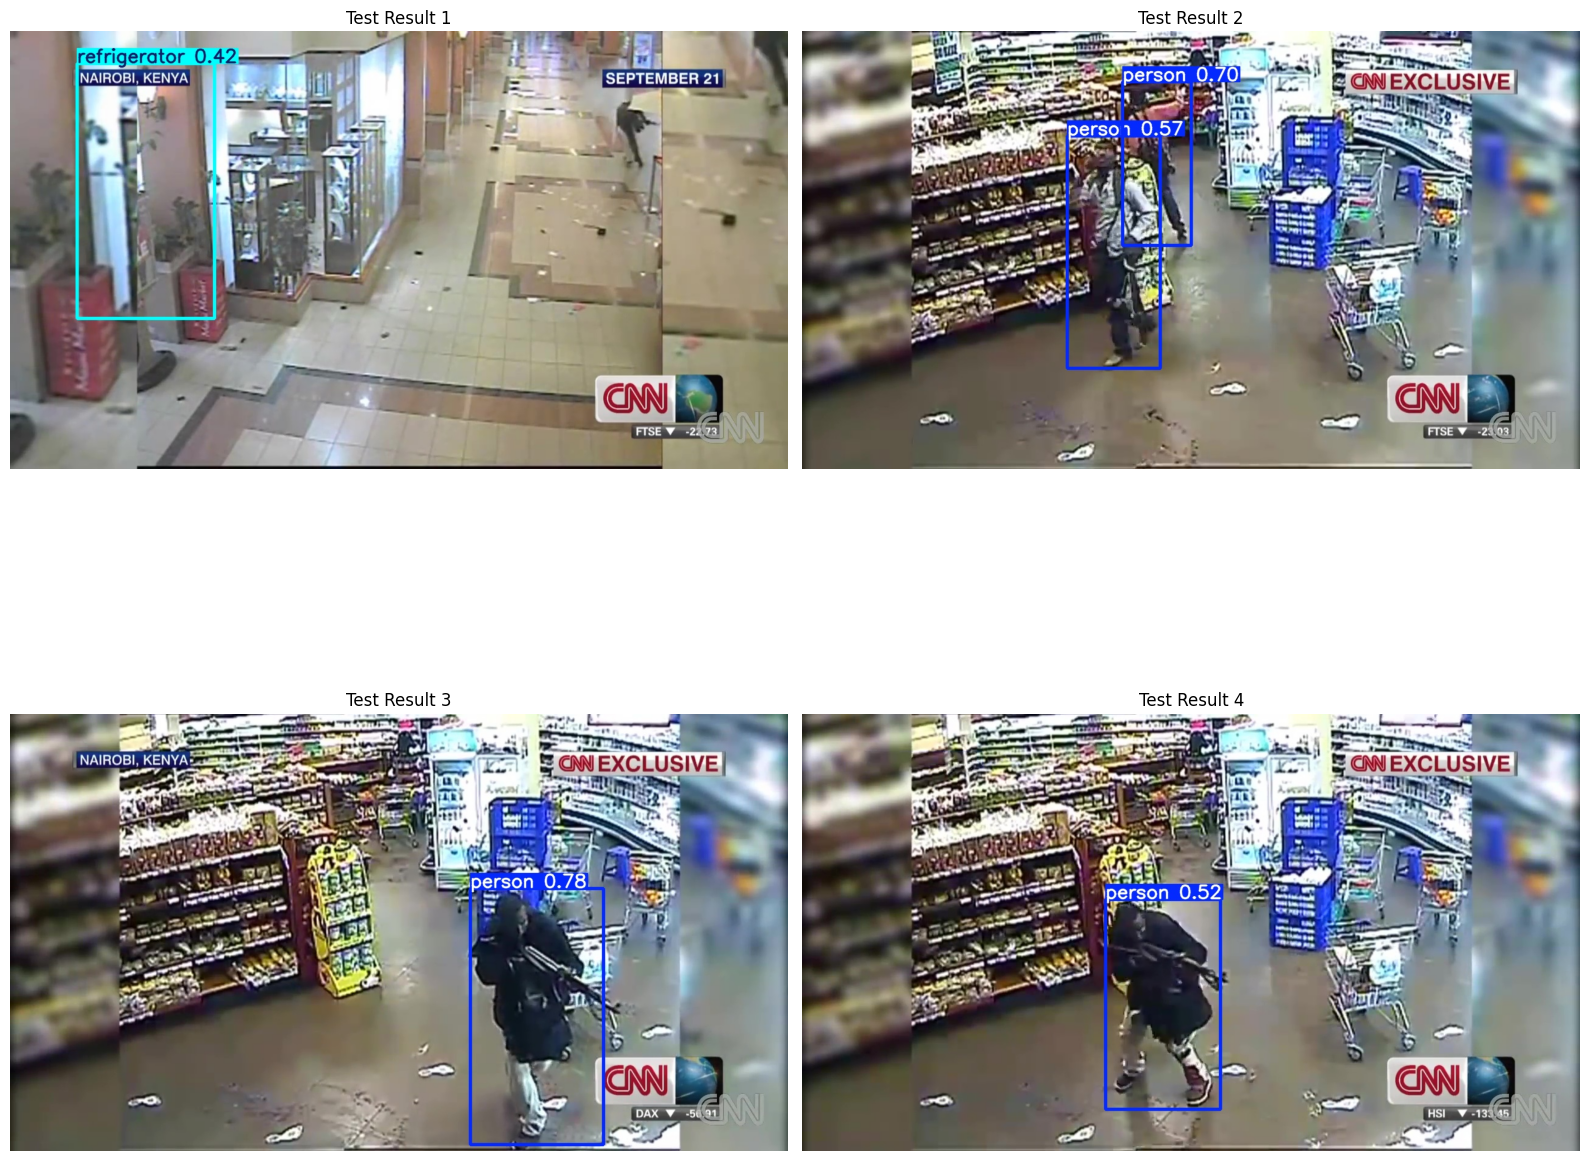


✓ Results displayed and saved as: test_results.png

✓ Testing complete!


In [100]:
# testing

print("\n" + "="*80)
print("MODEL TESTING")
print("="*80)

import os
from pathlib import Path

# Check if trained model exists
model_path = f'runs/detect/{PROJECT_NAME}/weights/best.pt'

if os.path.exists(model_path):
    print(f"✓ Loading trained model from: {model_path}")
    best_model = YOLO(model_path)
else:
    print(f"⚠ Trained model not found at: {model_path}")
    print("Using pre-trained model instead...")
    best_model = YOLO('yolov8n.pt')

def test_on_image(image_path):

    results = best_model.predict(source=image_path, conf=0.25, save=True)

    result = results[0]

    print(f"\nResults for {Path(image_path).name}:")

    if len(result.boxes) > 0:
        for box in result.boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            class_name = best_model.names[cls]  # Get class name from model
            print(f"  - {class_name}: {conf:.2%}")
    else:
        print("  No detections")

    return result

# Test on validation images
val_img_dir = Path(DATASET_PATH) / 'val' / 'images'

if val_img_dir.exists():
    val_images = list(val_img_dir.glob('*.jpg')) + list(val_img_dir.glob('*.png'))

    if val_images:
        print(f"\n✓ Found {len(val_images)} validation images")
        print("Testing on random samples...")

        # Test on 5 random images
        test_samples = random.sample(val_images, min(5, len(val_images)))

        for img_path in test_samples:
            result = test_on_image(str(img_path))

        print(f"\n✓ Results saved in: runs/detect/predict/")
    else:
        print("No validation images found")
else:
    print("Validation folder not found")
    print("Testing on dataset images instead...")

    # Fallback: test on any images from dataset
    test_imgs = list(Path(DATASET_PATH).glob('**/*.jpg'))[:5]

    if test_imgs:
        for img_path in test_imgs:
            result = test_on_image(str(img_path))
    else:
        print(" No images found to test")

# Display results
print("\n" + "="*80)
print("DISPLAYING RESULTS")
print("="*80)

import matplotlib.pyplot as plt
import cv2

# Find the latest prediction folder
predict_folders = list(Path('runs/detect').glob('predict*'))

if predict_folders:
    latest_predict = max(predict_folders, key=os.path.getmtime)
    result_images = list(latest_predict.glob('*.jpg')) + list(latest_predict.glob('*.png'))

    if result_images:
        print(f"✓ Found {len(result_images)} result images")

        # Display up to 4 results
        fig, axes = plt.subplots(2, 2, figsize=(16, 16))
        axes = axes.ravel()

        for idx, img_path in enumerate(result_images[:4]):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f'Test Result {idx+1}')

        plt.tight_layout()
        plt.savefig('test_results.png', dpi=150, bbox_inches='tight')
        plt.show()

        print("\n✓ Results displayed and saved as: test_results.png")
    else:
        print(" No result images found")
else:
    print(" No prediction results found")

print("\n✓ Testing complete!")